# Getting Started with Temporian

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/temporian/blob/last-release/docs/src/tutorials/getting_started.ipynb)

## Setup

In [1]:
import numpy as np
import pandas as pd

# Theoretical (Population) Standard Deviation
def population_std(data):
    mean = np.mean(data)
    return np.sqrt(np.sum((data - mean) ** 2) / len(data))

# Sample Standard Deviation
def sample_std(data):
    return np.std(data, ddof=1)

# Rolling Standard Deviations
def rolling_std(data, window_size, std_type='sample'):
    if std_type == 'sample':
        return data.rolling(window=window_size).apply(sample_std)
    elif std_type == 'population':
        return data.rolling(window=window_size).apply(population_std)
    else:
        raise ValueError("Invalid std_type. Choose either 'sample' or 'population'.")

# Example usage:
data = pd.Series([2, 4, 4, 4, 5, 5, 7, 9])  # Replace this with your column
window_size = 3

rolling_sample_sd = rolling_std(data, window_size, std_type='sample')
rolling_population_sd = rolling_std(data, window_size, std_type='population')

print(rolling_sample_sd)
print(rolling_population_sd)


0         NaN
1         NaN
2    1.154701
3    0.000000
4    0.577350
5    0.577350
6    1.154701
7    2.000000
dtype: float64
0         NaN
1         NaN
2    0.942809
3    0.000000
4    0.471405
5    0.471405
6    0.942809
7    1.632993
dtype: float64


In [2]:
# Skip this cell if you are running the notebook locally and have already installed temporian.
%pip install temporian -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.8/637.8 kB 8.2 MB/s eta 0:00:00


In [3]:
import temporian as tp

import pandas as pd
import numpy as np

In [6]:
data

0    2
1    4
2    4
3    4
4    5
5    5
6    7
7    9
dtype: int64

In [8]:
# # Convert the DataFrame into a Temporian EventSet
# evset_signals = tp.from_pandas(data)

# evset_signals

In [ ]:
trend = signal.moving_standard_deviation(tp.duration.seconds(30))


## Example Data

This minimal data consists of just one `signal` with a `timestamp` for each sample.

The signal is a periodic sinusoidal `season` with a slight positive slope in the long run, which we call `trend`. Plus the ubiquitous `noise`.

In [16]:
# Generate a synthetic dataset
timestamps = np.arange(0, 100, 1)
n = len(timestamps)
noise = 0.1 * np.random.randn(n)
trend = 0.01 * timestamps
season = 0.4 * np.sin(timestamps)

# Convention: 'df_' for DataFrame
df_signals = pd.DataFrame(
    {
        "timestamp": timestamps,
        "noise": noise,
        "trend": trend,
        "season": season,
        "signal": noise + trend + season,
    }
)

df_signals

,timestamp,noise,trend,season,signal
0,0,0.151640,0.00,0.000000,0.151640
1,1,0.140497,0.01,0.336588,0.487085
2,2,0.028480,0.02,0.363719,0.412199
3,3,-0.032665,0.03,0.056448,0.053783
4,4,0.102614,0.04,-0.302721,-0.160107
...,...,...,...,...,...
95,95,-0.043638,0.95,0.273305,1.179666
96,96,-0.031240,0.96,0.393435,1.322195
97,97,-0.145513,0.97,0.151843,0.976331
98,98,-0.087856,0.98,-0.229353,0.662791


## Part 1: Loading Data

Any kind of signal is represented in Temporian as a **collection of events**, using the `EventSet` object.

In this case there's no `indexes` because we only have one sequence.

Indices could be useful if we had multiple signals in parallel.
For example, imagine that we needed to work with signals from multiple sensor devices, or represent the sales from many stores or products: we could separate them by setting the correct features as indexes for each one.

In [17]:
# Convert the DataFrame into a Temporian EventSet
evset_signals = tp.from_pandas(df_signals)

evset_signals

timestamp,noise,trend,season,signal
0,0.1516,0,0,0.1516
1,0.1405,0.01,0.3366,0.4871
2,0.02848,0.02,0.3637,0.4122
3,-0.03266,0.03,0.05645,0.05378
4,0.1026,0.04,-0.3027,-0.1601
…,…,…,…,…


In [ ]:
# Plot the dataset
_ = evset_signals.plot()

**Note:** If you're wondering why the plot has an empty `()` in the title, it's because we have no `indexes`, as mentioned above.

## Part 2: Using Operators

Now, let's actually transform our data with a couple operations.

To extract only the long-term trend, the sine and noise signals are first removed using a moving average over a large moving window (they have zero mean).

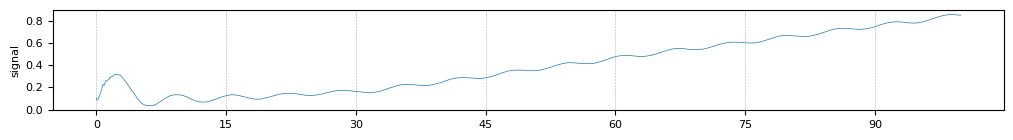

In [11]:
# Pick only one feature
signal = evset_signals["signal"]

# Moving avg
trend = signal.simple_moving_average(tp.duration.seconds(30))
trend.plot()

In [32]:
signal = evset_signals["signal"]
signal

timestamp,signal
0,0.1516
1,0.4871
2,0.4122
3,0.05378
4,-0.1601
…,…


In [33]:
trend = signal.moving_standard_deviation(window_size)


In [34]:
trend


timestamp,signal
0,0
1,0.1677
2,0.1438
3,0.1891
4,0.2361
…,…


In [14]:
rolling_sample_sd = rolling_std(df_signals["signal"], window_size, std_type='sample')
rolling_population_sd = rolling_std(df_signals["signal"], window_size, std_type='population')

In [35]:
rolling_sample_sd

0           NaN
1           NaN
2      0.021796
3      0.051562
4      0.058991
         ...   
995    0.109772
996    0.074240
997    0.061682
998    0.029265
999    0.141532
Name: signal, Length: 1000, dtype: float64

In [15]:
rolling_population_sd

0           NaN
1           NaN
2      0.017796
3      0.042100
4      0.048166
         ...   
995    0.089629
996    0.060616
997    0.050363
998    0.023895
999    0.115560
Name: signal, Length: 1000, dtype: float64

In [23]:
import numpy as np

def rolling_standard_deviation(data, window_size):
    # Calculate the rolling sum and rolling sum of squares using a window
    rolling_sum = np.cumsum(data)
    rolling_sum2 = np.cumsum(data**2)

    # Adjust the sums to account for the window size
    rolling_sum = rolling_sum[window_size:] - np.insert(rolling_sum[:-window_size], 0, 0)
    rolling_sum2 = rolling_sum2[window_size:] - np.insert(rolling_sum2[:-window_size], 0, 0)

    # Use the formula to compute the rolling standard deviation
    mean = rolling_sum / window_size
    return np.sqrt((rolling_sum2 / window_size) - mean**2)


In [38]:
import numpy as np

def rolling_standard_deviation(data, window_size):
    # Convert data to numpy array for processing
    data = np.array(data)

    # Calculate the rolling sum and rolling sum of squares using a window
    rolling_sum = np.cumsum(data)
    rolling_sum2 = np.cumsum(data**2)

    # Adjust the sums to account for the window size
    rolling_sum = rolling_sum[window_size:] - np.insert(rolling_sum[:-window_size], 0, 0)
    rolling_sum2 = rolling_sum2[window_size:] - np.insert(rolling_sum2[:-window_size], 0, 0)

    # Use the formula to compute the rolling standard deviation
    mean = rolling_sum / window_size
    return np.sqrt((rolling_sum2 / window_size) - mean**2)


In [40]:
import numpy as np

def rolling_standard_deviation(data, window_size):
    # Convert data to numpy array for processing
    data = np.array(data)

    # Calculate the rolling sum and rolling sum of squares using a window
    rolling_sum = np.cumsum(data)
    rolling_sum2 = np.cumsum(data**2)

    # Adjust the sums to account for the window size
    rolling_sum = np.array([rolling_sum[i] - (rolling_sum[i - window_size] if i - window_size >= 0 else 0) for i in range(len(rolling_sum))])
    rolling_sum2 = np.array([rolling_sum2[i] - (rolling_sum2[i - window_size] if i - window_size >= 0 else 0) for i in range(len(rolling_sum2))])

    # Truncate the sums to match the window size
    rolling_sum = rolling_sum[window_size - 1:]
    rolling_sum2 = rolling_sum2[window_size - 1:]

    # Use the formula to compute the rolling standard deviation
    mean = rolling_sum / window_size
    return np.sqrt((rolling_sum2 / window_size) - mean**2)


In [41]:
import numpy as np

def rolling_standard_deviation(data, window_size):
    data = np.array(data)

    sum_values = np.sum(data[:window_size])
    sum_square_values = np.sum(data[:window_size] ** 2)
    num_values = window_size

    result = []
    for i in range(len(data) - window_size + 1):
        mean = sum_values / num_values
        std_dev = np.sqrt((sum_square_values / num_values) - mean ** 2)
        result.append(std_dev)

        # If we're not at the last window, adjust the sums for the next window
        if i < len(data) - window_size:
            sum_values = sum_values - data[i] + data[i + window_size]
            sum_square_values = sum_square_values - data[i] ** 2 + data[i + window_size] ** 2

    return np.array(result)


In [44]:
import numpy as np

def rolling_standard_deviation(data, window_size):
    data = np.array(data)

    result = []
    for i in range(len(data)):
        # Adjust the window size for the start of the data
        current_window_size = min(i + 1, window_size)

        sum_values = np.sum(data[i - current_window_size + 1:i + 1])
        sum_square_values = np.sum(data[i - current_window_size + 1:i + 1] ** 2)
        num_values = current_window_size

        mean = sum_values / num_values
        std_dev = np.sqrt((sum_square_values / num_values) - mean ** 2)
        result.append(std_dev)

    return np.array(result)


In [46]:
def rolling_sample_standard_deviation(data, window_size):
    data = np.array(data)

    result = []
    for i in range(len(data)):
        # Adjust the window size for the start of the data
        current_window_size = min(i + 1, window_size)

        sum_values = np.sum(data[i - current_window_size + 1:i + 1])
        sum_square_values = np.sum(data[i - current_window_size + 1:i + 1] ** 2)
        num_values = current_window_size

        mean = sum_values / num_values

        # Sample standard deviation formula
        if num_values > 1:
            std_dev = np.sqrt((sum_square_values - num_values * mean**2) / (num_values - 1))
        else:
            std_dev = 0  # If there's only one data point in the window, the standard deviation is 0

        result.append(std_dev)

    return np.array(result)

rolling_sample_standard_deviation


<function __main__.rolling_sample_standard_deviation(data, window_size)>

In [48]:
rolling_sample_standard_deviation(df_signals["signal"], window_size)

array([0.        , 0.23719542, 0.17607868, 0.23159615, 0.28917862,
       0.19656454, 0.10193421, 0.27060045, 0.3038517 , 0.12804956,
       0.32408127, 0.34402894, 0.12422181, 0.24822483, 0.29149883,
       0.16651063, 0.25291937, 0.30925186, 0.15796388, 0.23541397,
       0.35344084, 0.20591655, 0.14086184, 0.40684701, 0.30999519,
       0.24535209, 0.37682967, 0.31976195, 0.1705567 , 0.36260966,
       0.27051784, 0.10485339, 0.16272971, 0.30609854, 0.24262345,
       0.30345371, 0.39436615, 0.27359343, 0.36443064, 0.36369735,
       0.18012944, 0.2703588 , 0.30067222, 0.14368458, 0.26003815,
       0.34645601, 0.19010902, 0.15028072, 0.40721965, 0.31200658,
       0.13416873, 0.43204305, 0.33600888, 0.10551956, 0.26509873,
       0.20127336, 0.01967991, 0.16628085, 0.29970535, 0.15241307,
       0.23889603, 0.2347201 , 0.15966619, 0.31554184, 0.40980145,
       0.08950224, 0.14407313, 0.30044677, 0.17191098, 0.11288656,
       0.26058103, 0.26089857, 0.21894285, 0.3170711 , 0.21397

In [43]:
trend

timestamp,signal
0,0
1,0.1677
2,0.1438
3,0.1891
4,0.2361
…,…


In [21]:
import numpy as np

def rolling_standard_deviation(data, window_size):
    # Calculate the rolling sum and rolling sum of squares
    rolling_sum = np.cumsum(data)
    rolling_sum2 = np.cumsum(data**2)

    # Calculate the rolling sum and rolling sum of squares for the window
    rolling_sum = rolling_sum[window_size:] - rolling_sum[:-window_size]
    rolling_sum2 = rolling_sum2[window_size:] - rolling_sum2[:-window_size]

    # Use the formula to compute the rolling standard deviation
    mean = rolling_sum / window_size
    return np.sqrt((rolling_sum2 / window_size) - mean**2)


In [22]:
rolling_standard_deviation(df_signals["signal"], window_size)

0     NaN
1     NaN
2     NaN
3     0.0
4     0.0
     ... 
95    0.0
96    0.0
97    NaN
98    NaN
99    NaN
Name: signal, Length: 100, dtype: float64

In [ ]:
# Pick only one feature
signal = evset_signals["signal"]

# Moving avg
trend = signal.simple_moving_average(tp.duration.seconds(30))
trend.plot()

Notice that the feature is still named `signal`?

Let's give it a new name to avoid confusions.

In [ ]:
# Let's rename the feature by adding a prefix
trend = trend.prefix("trend_")
trend.plot()

Now we've the long-term trend, we can subtract it from the original signal to get only the `season` component.

In [ ]:
# Remove the slow 'trend' to get 'season'
detrend = signal - trend

# Rename resulting feature
detrend = detrend.rename("detrend")

detrend.plot()

Using a shorter moving average, we can filter out the noise.

In [ ]:
denoise = detrend.simple_moving_average(tp.duration.seconds(1.5)).rename("denoise")
denoise.plot()

### Selecting and combining features

Features can be selected and combined to create new `EventSets` using two operations:
1. **Select:** using `evset["feature_1"]` or `evset[["feature_1", "feature_2"]]` will return a new `EventSet` object with only one or two features respectively.
1. **Glue:** using `tp.glue(evset_1, evset_2)` will return a new `EventSet` combining all features from both inputs. But the feature names cannot be repeated, so you may need to use `prefix()` or `rename()` before combining.

Let's add some operations and then plot together everything:
- The `slope` of one of the signals is calculated, by subtracting a delayed version of itself. Note that the time axis for this plot is shifted.

In [ ]:
# Pack results to show all plots together
evset_result = tp.glue(
    signal,
    trend,
    detrend,
    denoise
)

evset_result.plot()

### Lag and resample

Just as another example, let's also calculate the derivative of the denoised signal, numerically.

In [ ]:
# Estimate numeric derivative

# Time step
delta_t = 1

# Increment in y axis
y = denoise
y_lag = y.lag(delta_t)
delta_y = y - y_lag.resample(y)

# Remember the formula? :)
derivative = delta_y / delta_t

# Also, let's use an interactive plot just for fun.
derivative.plot(interactive=True, width_px=600)

Pretty accurate! We had a `0.4` amplitude sine wave with unit frequency, so the derivative should be a `0.4` amplitude cosine.


Now, taking a look at the operators, the `lag()` call is pretty self-descriptive. But you might be wondering, why is the `resample()` operator needed?

That's because the `y.lag(delta_t)` just shifts the timestamps by `delta_t`, and as a result, `y` and `y_lag` are signals with **different samplings**.

But, how would you subtract two signals that are defined at different timestamps? In Temporian, we don't like error-prone implicit _magic_ behavior, so you have to do it explicitly. **You can only do arithmetics between signals with the same samplings.**

To create matching samplings, we explicitly use `y_lag.resample(y)`, creating a signal using the timestamps from `y`, but taking the values from `y_lag`. It's essentialy the same signal as `y_lag`, but sampled at the same timestamps as `y`.

### Exporting outputs from Temporian
You may need to use this data in different ways for downstream tasks, like training a model using whatever library you need.

If you can't use the data directly from Temporian, you can always go back to a pandas DataFrame:

In [ ]:
tp.to_pandas(evset_result)

## Part 3: Using an index
This is the final important concept to get from this introduction.

Indexes are useful to handle multiple signals in parallel (as mentioned at the top of this notebook).
For example, working with signals from multiple sensor devices or representing sales from many stores or products. The feature names may be exactly the same for all the data, but we need to separate them by setting the correct `index` for each one.

### New example data: multiple devices
Let's create two signals with overlapping timestamps, with a different `device_id`:

In [ ]:

# Two devices with overlapping timestamps
df_device_1 = df_signals[:900].copy()
df_device_2 = df_signals[300:].copy()

# Add a column with device_id and concat
df_device_1["device_id"] = "Device 1"
df_device_2["device_id"] = "Device 2"
df_both_devices = pd.concat([df_device_1, df_device_2])

# Create evset using 'device_id' as index
evset_devices = tp.from_pandas(df_both_devices, indexes=["device_id"])
evset_devices

As you can see above, each index has it's own timestamps and feature values. They will always have the same features though, because they're on the same `EventSet`.

The plots also accomodate to show each index separately. In particular, see below how the timestamps are different and partly overlapping, and that's completely fine for separate indices. This wouldn't be possible by using different feature names for each sensor, for example.

In [ ]:
evset_devices["signal"].plot()

### Operations with index

Any operator that we apply now, is aware of the `index` and will be performed over each one separately.

In [ ]:
# Apply some operations
trend_i = evset_devices["signal"].simple_moving_average(tp.duration.seconds(30))
detrend_i = evset_devices["signal"] - trend_i
denoise_i = detrend_i.simple_moving_average(tp.duration.seconds(1.5))

# Plot for each index
tp.glue(evset_devices["signal"],
        detrend_i.rename("detrend"),
        denoise_i.rename("denoise")
       ).plot()

### Multi-indexes

Finally, let's point out that multiple columns of the input data may be set as indexes.

For example, in the case of sales in a store, we could use both the store and product columns to group the sequences. In this case, each group would contain the sales for a single product in a single store.

This is easy to do since the `indexes` argument is actually a list of columns, and each group represented in Temporian by using a tuple `(store, product)` as the index key.

## Summary

Congratulations! You now have the basic concepts needed to create a data preprocessing pipeline with Temporian:
- Defining an **EventSet** and using **operators** on it.
- Combine **features** using **select** and **glue**.
- Coverting data back and forth between Temporian's **EventSet** and pandas **DataFrames**.
- Visualizing input/output data using **EventSet.plot()**.
- Operating and plotting with an **index**.

### Other important details

To keep it short and concise, there are interesting concepts that were not mentioned above:

- You might as well use **datetimes** to specify the timestamps. Learn more about it on the [**Time Units** section of the User Guide](https://temporian.readthedocs.io/en/latest/user_guide/#time-units). There are many [**calendar operators**](https://temporian.readthedocs.io/en/stable/reference/temporian/operators/calendar/calendar_day_of_month/) available when working with date timestamps.
- Temporian can handle **non-uniform samplings** just as easily (non-equal distance between event timestamps). Read more about the data representation on the **[User Guide's introduction](https://temporian.readthedocs.io/en/latest/user_guide/)** or check the [**sampling** section](https://temporian.readthedocs.io/en/latest/user_guide/#sampling).
- Temporian is **strict on the feature types** when applying operations, to avoid potentially silent errors or memory issues. Check the [User Guide's **casting** section](https://temporian.readthedocs.io/en/latest/user_guide/#casting) section to learn how to tackle those cases.
- We only used moving average here, but there are a bunch of other [**moving window**](https://temporian.readthedocs.io/en/stable/reference/temporian/operators/window/moving_count/) operators, frequently useful for time sequences manipulation.

### Next Steps
- The [**Recipes**](https://temporian.readthedocs.io/en/latest/recipes/) are short and self-contained examples showing how to use Temporian in typical use cases.
- Try the more advanced [**tutorials**](https://temporian.readthedocs.io/en/latest/tutorials/) to continue learning by example about all these topics and more!
- We could only cover a small fraction of **[all available operators](https://temporian.readthedocs.io/en/stable/reference/temporian/operators/add_index/)**.
- We put a lot of ❤️ in the **[User Guide](https://temporian.readthedocs.io/en/latest/user_guide/)**, so make sure to check it out 🙂.